# Directivities demo

The goal of this notebook is to demonstrate how microphone and source directivities can be taken into account in room impulse response (RIR) simulation with `pyroomacoustics`.

At the time of writing (August 31, 2021), the following is supported:
- Microphone directivities with the Image Source Method (ISM) for shoebox and arbitrary shape rooms.
- Source directivies with ISM for only shoebox rooms.

Below is a list of what this notebook covers. 

1. [Available directivity patterns](#pattern)
2. [Microphone directivity](#mic)
3. [Rotating microphone](#rotate)
4. [Source directivity](#source)
5. [Microphone array directivities](#micarray)
    - [Same directivity for all microphones](#same)
    - [Different directivity for each microphone](#diff)
    - [Helper function for circular microphone arrays](#circ)

Let's begin with the necessary imports.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyroomacoustics as pra
from pyroomacoustics import dB
from pyroomacoustics.directivities import (
    DirectivityPattern,
    DirectionVector,
    CardioidFamily,
)
from pyroomacoustics.doa import spher2cart
from scipy.io import wavfile
import IPython

fs, signal = wavfile.read("arctic_a0010.wav")
signal = signal / np.max(np.abs(signal)) * 0.1    # so that simulation is wihtin [-1, 1] for normalize=False

<a id='pattern'></a>
## Available directivity patterns

There are four (frequency-indepdender) directivities that can be used out-of-the box:
- Figure eight 
- Hyper-cardioid
- Cardioid
- Sub-cardioid.

Below is a comparison of their 2D polar patterns.

/Users/eric/GITHUB/forked_repos/satvik/pyroomacoustics/pyroomacoustics/utilities.py:321: RuntimeWarning: divide by zero encountered in log10
  return 20 * np.log10(np.abs(signal))


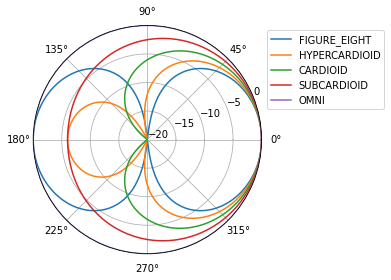

In [2]:
# angles to plot over
angles = np.linspace(start=0, stop=360, num=361, endpoint=True)
angles = np.radians(angles)
cart = spher2cart(azimuth=angles)
lower_gain = -20

# plot each pattern
fig = plt.figure()
ax = plt.subplot(111, projection="polar")
for pattern in DirectivityPattern:

    dir_obj = CardioidFamily(
        orientation=DirectionVector(azimuth=0, colatitude=90, degrees=True), 
        pattern_enum=pattern
    )
    resp = dir_obj.get_response(coord=cart, magnitude=True)
    resp_db = dB(np.array(resp))
    ax.plot(angles, resp_db, label=pattern.name)

plt.legend(bbox_to_anchor=(1, 1))
plt.ylim([lower_gain, 0])
ax.yaxis.set_ticks(np.arange(start=lower_gain, stop=5, step=5))
plt.tight_layout()

Support for 3D is also available.

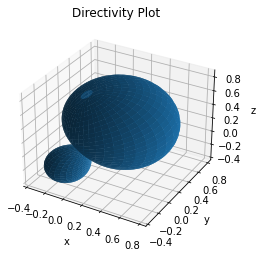

In [3]:
pattern = DirectivityPattern.HYPERCARDIOID
orientation = DirectionVector(azimuth=45, colatitude=45, degrees=True)

# create cardioid object
dir_obj = CardioidFamily(orientation=orientation, pattern_enum=pattern)

# plot
azimuth = np.linspace(start=0, stop=360, num=361, endpoint=True)
colatitude = np.linspace(start=0, stop=180, num=180, endpoint=True)
dir_obj.plot_response(azimuth=azimuth, colatitude=colatitude, degrees=True);

<a id='mic'></a>
## Microphone directivity

Adding a directivity to a microphone is as simple as passing a `Directivity` object to the a room's `add_microphone` method.

In [4]:
mic_pattern = DirectivityPattern.HYPERCARDIOID

# create room with single source and microphone
room = pra.ShoeBox(
    p=[5, 3, 3],
    materials=pra.Material(0.4),
    fs=16000,
    max_order=40,
)
room.add_source(position=[1, 1, 1.8])
mic_dir = CardioidFamily(
    orientation=DirectionVector(azimuth=180, colatitude=60, degrees=True),
    pattern_enum=mic_pattern,
)
room.add_microphone(loc=[3.5, 1.8, 1.0], directivity=mic_dir);

We can then plot the room to see the set directivity.

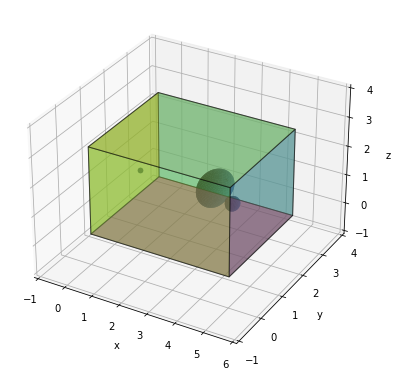

In [5]:
fig, ax = room.plot()
ax.set_xlim([-1, 6])
ax.set_ylim([-1, 4])
ax.set_zlim([-1, 4])
ax.set_title("")
fig.set_size_inches(10, 5);

Simulating the RIR will take into account the specified directivity.

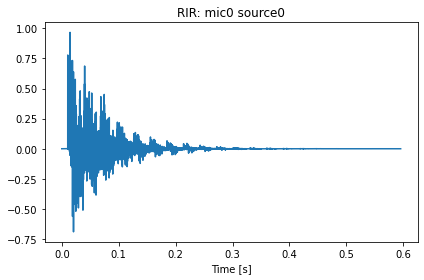

In [6]:
room.plot_rir()

<a id='rotate'></a>
## Rotating microphone

Let's to a simple listening test to see how setting the directivity affects the simulation of a source, namely we will rotate the microphone's directivity pattern. 

Here's the original file.

In [7]:
print("Original WAV:")
IPython.display.Audio(signal, rate=fs, normalize=False)

Original WAV:


ANGLE : 0.0
Estimated RT60 : 0.276625


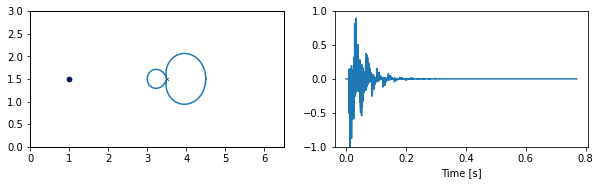

<Figure size 432x288 with 0 Axes>

ANGLE : 90.0
Estimated RT60 : 0.1955625


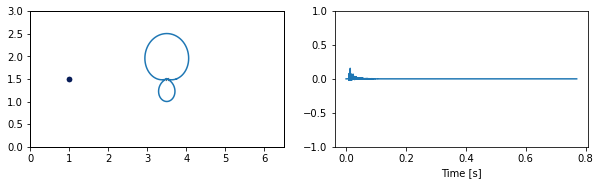

<Figure size 432x288 with 0 Axes>

ANGLE : 180.0
Estimated RT60 : 0.27975


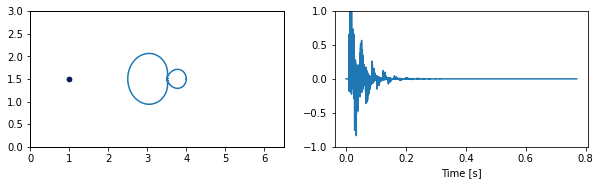

<Figure size 432x288 with 0 Axes>

ANGLE : 270.0
Estimated RT60 : 0.1955625


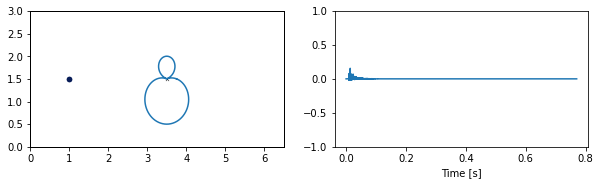

<Figure size 432x288 with 0 Axes>

In [8]:
# rotate microphone directivity and simulate
n = 4
pattern = DirectivityPattern.HYPERCARDIOID
res = []
for i in range(n): 
    angle = 360 * i / n
    print("ANGLE : {}".format(angle))
    
    # create room
    room_dim = [6.5, 3, 3]
    room  = pra.ShoeBox(
        p=room_dim,
        materials=pra.Material(0.6),
        fs=16000,
        max_order=40,
    )

    # add source signal
    source_loc = [1, 1.5, 1.5]
    room.add_source(source_loc, signal=signal)

    # add microphone with directivity
    mic_loc = [3.5, 1.5, 1.5]
    directivity = CardioidFamily(
        orientation=DirectionVector(azimuth=angle, colatitude=90, degrees=True), 
        pattern_enum=pattern
    )
    room.add_microphone(mic_loc, directivity=directivity)
    
    # simulate
    room.simulate()
    
    est_rt_60 = pra.experimental.rt60.measure_rt60(room.rir[0][0], fs=16000)
    print("Estimated RT60 : {}".format(est_rt_60))
    
    # plot bird's eye view
    room_2d  = pra.ShoeBox(p=room_dim[:2])
    room_2d.add_source(source_loc[:2])
    directivity_2d = CardioidFamily(
        orientation=DirectionVector(azimuth=angle, degrees=True), 
        pattern_enum=pattern
    )
    room_2d.add_microphone(mic_loc[:2], directivity=directivity_2d)
    
    _, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 2.5))
    room_2d.plot(ax=ax[0])
    n_samples = len(room.rir[0][0])
    t_vals = np.arange(n_samples) / room.fs
    ax[1].plot(t_vals, room.rir[0][0])
    ax[1].set_xlabel("Time [s]")
    ax[1].set_ylim([-1, 1])
    plt.show()
    
    # output signal
    IPython.display.display(IPython.display.Audio(room.mic_array.signals[0,:], rate=fs, normalize=False))
    res.append(room.rir[0][0])

<a id='source'></a>
## Source directivity

Adding a directivity to a source is as simple as passing a `Directivity` object to the a room's `add_source` method.

In [9]:
source_pattern = DirectivityPattern.HYPERCARDIOID

# create room with single source and microphone
room = pra.ShoeBox(
    p=[5, 3, 3],
    materials=pra.Material(0.4),
    fs=16000,
    max_order=40,
)
source_dir = CardioidFamily(
    orientation=DirectionVector(azimuth=0, colatitude=60, degrees=True),
    pattern_enum=source_pattern,
)
room.add_source(position=[1, 1, 1.8], directivity=source_dir)
room.add_microphone(loc=[3.5, 1.8, 1.0]);

We can then plot the room to see the set directivity.

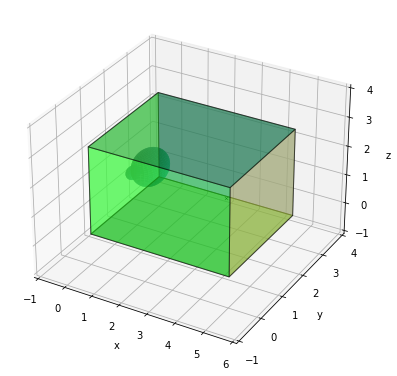

In [10]:
fig, ax = room.plot()
ax.set_xlim([-1, 6])
ax.set_ylim([-1, 4])
ax.set_zlim([-1, 4])
ax.set_title("")
fig.set_size_inches(10, 5);

<a id='micarray'></a>
## Microphone array directivities

For specifying the directivities of multiple microphones at once, there are a few approaches.

<a id='same'></a>
### 1) Same directivity for all microphones

Just requires creating one directivity object. Note that we use the `add_microphone_array` method of the `Room` object!

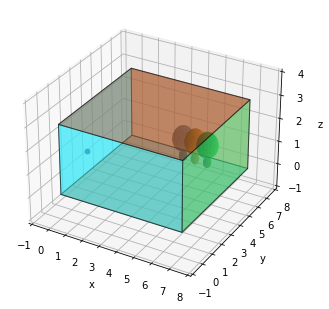

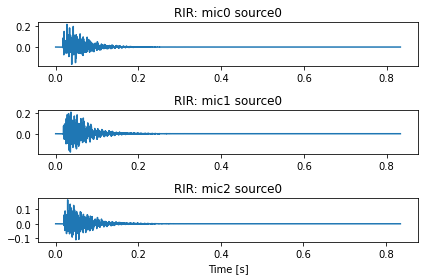

In [11]:
pattern = DirectivityPattern.HYPERCARDIOID
orientation = DirectionVector(azimuth=0, colatitude=0, degrees=True)

# create room
room = pra.ShoeBox(
    p=[7, 7, 3],
    materials=pra.Material(0.4),
    fs=16000,
    max_order=40,
)

# add source
room.add_source([1, 1, 1.7])

# add linear microphone array
M = 3
R = pra.linear_2D_array(center=[5, 5], M=M, phi=0, d=0.7)
R = np.concatenate((R, np.ones((1, M))))
directivity = CardioidFamily(orientation=orientation, pattern_enum=pattern)
room.add_microphone_array(R, directivity=directivity)

# plot room
fig, ax = room.plot()
ax.set_title("")
ax.set_xlim([-1, 8])
ax.set_ylim([-1, 8])
ax.set_zlim([-1, 4])

# plot
room.plot_rir()

<a id='diff'></a>
### 2) Different directivity for each microphone

For this, a separate directivity object needs to be created for each microphone.

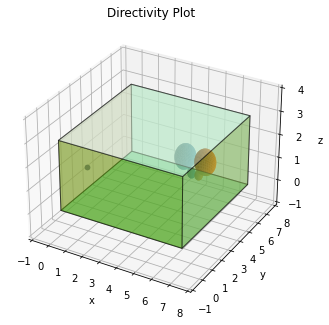

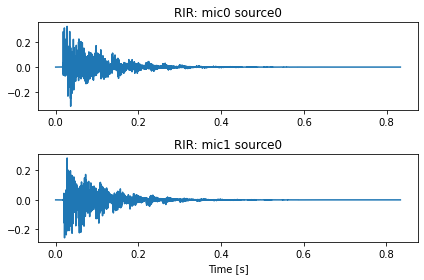

In [12]:
dir_1 = CardioidFamily(
    orientation=DirectionVector(azimuth=180, colatitude=30, degrees=True),
    pattern_enum=DirectivityPattern.HYPERCARDIOID,
)
dir_2 = CardioidFamily(
    orientation=DirectionVector(azimuth=0, colatitude=30, degrees=True),
    pattern_enum=DirectivityPattern.HYPERCARDIOID,
)

# create room
room = pra.ShoeBox(
    p=[7, 7, 3],
    materials=pra.Material(0.4),
    fs=16000,
    max_order=40,
)

# add source
room.add_source([1, 1, 1.7])

# add linear microphone array
M = 2
R = pra.linear_2D_array(center=[5, 5], M=M, phi=0, d=0.7)
R = np.concatenate((R, np.ones((1, M))))
room.add_microphone_array(R, directivity=[dir_1, dir_2])

# plot room
fig, ax = room.plot()
ax.set_xlim([-1, 8])
ax.set_ylim([-1, 8])
ax.set_zlim([-1, 4])

# plot
room.plot_rir()

<a id='circ'></a>
### 3) Helper function for circular microphone arrays

For such arrays, the function `pyroomacoustics.beamforming.circular_microphone_array_xyplane` can be to create a `MicrophoneArray` with a circular array configuration and the specified directivity facing outwards.

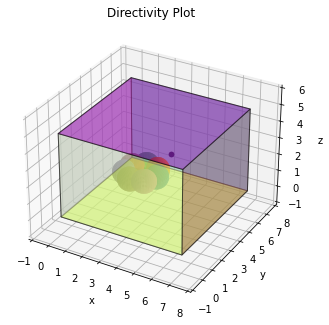

In [13]:
mic_rotation = 0
room_dim = [7, 7, 5]
source_loc = [5, 2.5, 4]
center = [3, 3, 2]
colatitude = 90

# make a room
room = pra.ShoeBox(p=room_dim)

# add source
room.add_source(source_loc)

# add circular microphone array
pattern = DirectivityPattern.CARDIOID
orientation = DirectionVector(azimuth=mic_rotation, colatitude=colatitude, degrees=True)
directivity = CardioidFamily(orientation=orientation, pattern_enum=pattern)
mic_array = pra.beamforming.circular_microphone_array_xyplane(
    center=center,
    M=7,
    phi0=mic_rotation,
    radius=50e-2,
    fs=room.fs,
    directivity=directivity,
)
room.add_microphone_array(mic_array)

# plot everything
fig, ax = room.plot()
ax.set_xlim([-1, 8])
ax.set_ylim([-1, 8])
ax.set_zlim([-1, 6]);

It also works in 2D.

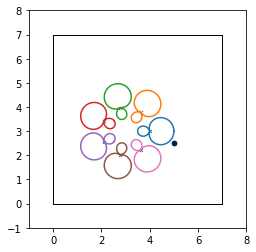

In [14]:
mic_rotation = 0
room_dim = [7, 7]
source_loc = [5, 2.5]
center = [3, 3]

# make a room
room = pra.ShoeBox(p=room_dim)

# add source
room.add_source(source_loc)

# add circular microphone array
pattern = DirectivityPattern.HYPERCARDIOID
orientation = DirectionVector(azimuth=mic_rotation, degrees=True)
directivity = CardioidFamily(orientation=orientation, pattern_enum=pattern)
mic_array = pra.beamforming.circular_microphone_array_xyplane(
    center=center,
    M=7,
    phi0=mic_rotation,
    radius=100e-2,
    fs=room.fs,
    directivity=directivity,
)
room.add_microphone_array(mic_array)

# plot everything
fig, ax = room.plot()
ax.set_xlim([-1, 8])
ax.set_ylim([-1, 8]);